In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import torch  # type: ignore[import]
    import torch.nn as nn  # type: ignore[import]
    from torch.utils.data import TensorDataset, DataLoader, random_split  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "PyTorch is required for this notebook. Please install torch."
    ) from exc
try:
    from sklearn.preprocessing import MinMaxScaler  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "scikit-learn is required for this notebook. Please install scikit-learn."
    ) from exc

torch.manual_seed(42)

import sys
root_dir = os.path.abspath("..")
if root_dir not in sys.path:
    sys.path.append(root_dir)
# print("Project root in sys.path:", root_dir)

from src.config import (
    CMAPSS_DATASETS,
    MAX_RUL,
    SEQUENCE_LENGTH,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    LEARNING_RATE,
    NUM_EPOCHS
)
from src.data_loading import load_cmapps_subset, get_feature_drop_cols
from src.additional_features import create_physical_features
from src.training import train_and_evaluate_fd
from src.model import LSTMRULPredictor
from src.loss import rul_asymmetric_weighted_loss

from src.models.lstm_rul_mcdo import LSTMRULPredictorMCDropout



In [3]:
res_fd001_mcdo, metrics_fd001_mcdo = train_and_evaluate_fd(
    fd_id="FD001",
    model_class=LSTMRULPredictorMCDropout,
    loss_fn=rul_asymmetric_weighted_loss,
    num_epochs=25,          # kannst du lassen wie vorher
    batch_size=64,          # falls du diesen Parameter hast
)


=== Training subset FD001: 1 cond, 1 fault (HPC) ===
New columns successfully added. Current number of columns: 32
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  125
1             0.943169        0.2       0.403406  125
2             0.942554       -1.8       0.404505  125
3             0.943025        0.2       0.405834  125
4             0.942581        1.2       0.405831  125
New columns successfully added. Current number of columns: 30
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio
0             0.941903        0.3       0.405617
1             0.941083        1.3       0.403985
2             0.941997        1.3       0.404842
3             0.941000       -0.7       0.405550
4             0.942237       -1.7       0.404810
[FD001] Using PHYSICAL (continuous settings) feature set
Feature columns used for training:
['Setting1', 'Setting2', 'Sensor2', 'Sensor3', 'Sensor4', 'Sensor6', 'Sensor7', 'Sensor8', 'Sensor9', 'Sensor11'

In [6]:
from src.uncertainty import mc_dropout_predict_fd001

model_mcdo  = res_fd001_mcdo["model"]
scaler_mcdo = res_fd001_mcdo["scaler"]

mc_results_fd001 = mc_dropout_predict_fd001(
    model=model_mcdo,
    scaler=scaler_mcdo,
    n_samples=50,
    data_dir="../data/raw",
)

print(mc_results_fd001.head())
mc_results_fd001.to_csv("../results/FD001/FD001_mc_dropout_uncertainty.csv", index=False)



New columns successfully added. Current number of columns: 30
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio
0             0.941903        0.3       0.405617
1             0.941083        1.3       0.403985
2             0.941997        1.3       0.404842
3             0.941000       -0.7       0.405550
4             0.942237       -1.7       0.404810
  UnitNumber  TrueRUL  PredRUL_mean  PredRUL_std
0       (1,)    112.0    108.639206     7.232995
1       (2,)     98.0    107.170349     9.302489
2       (3,)     69.0     50.651546     5.150003
3       (4,)     82.0     78.654373     7.453916
4       (5,)     91.0     93.907356     8.951762


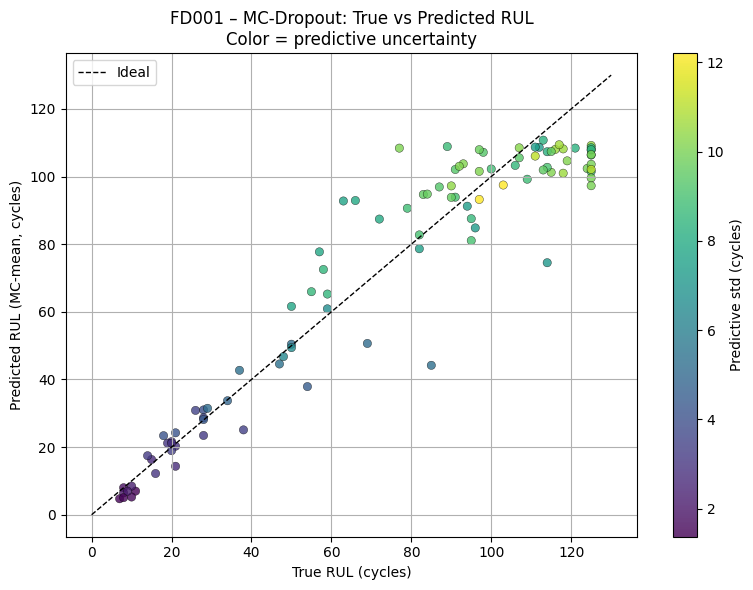

In [8]:
import matplotlib.pyplot as plt
import numpy as np

df = mc_results_fd001.copy()

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    df["TrueRUL"],
    df["PredRUL_mean"],
    c=df["PredRUL_std"],
    cmap="viridis",
    alpha=0.8,
    edgecolors="k",
    linewidths=0.3,
)

# Diagonale (perfekte Vorhersage)
rul_min = 0
rul_max = max(df["TrueRUL"].max(), df["PredRUL_mean"].max()) + 5
plt.plot([rul_min, rul_max], [rul_min, rul_max], "k--", linewidth=1, label="Ideal")

cbar = plt.colorbar(sc)
cbar.set_label("Predictive std (cycles)")

plt.xlabel("True RUL (cycles)")
plt.ylabel("Predicted RUL (MC-mean, cycles)")
plt.title("FD001 – MC-Dropout: True vs Predicted RUL\nColor = predictive uncertainty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


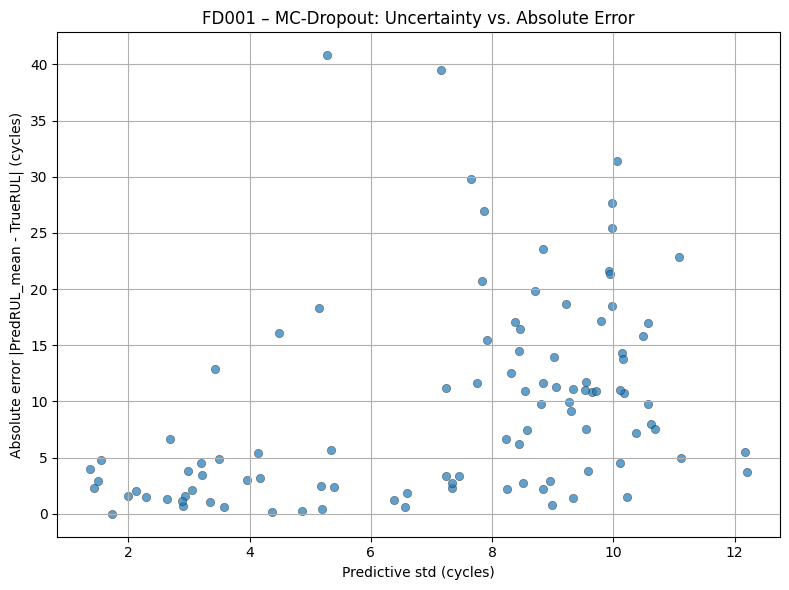

Correlation between PredRUL_std and |error|: 0.395


In [10]:
df = mc_results_fd001.copy()
df["Residual"] = df["PredRUL_mean"] - df["TrueRUL"]
df["AbsError"] = df["Residual"].abs()

plt.figure(figsize=(8, 6))
plt.scatter(
    df["PredRUL_std"],
    df["AbsError"],
    alpha=0.7,
    edgecolors="k",
    linewidths=0.3,
)
plt.xlabel("Predictive std (cycles)")
plt.ylabel("Absolute error |PredRUL_mean - TrueRUL| (cycles)")
plt.title("FD001 – MC-Dropout: Uncertainty vs. Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Korrelation ausgeben
corr = np.corrcoef(df["PredRUL_std"], df["AbsError"])[0, 1]
print(f"Correlation between PredRUL_std and |error|: {corr:.3f}")

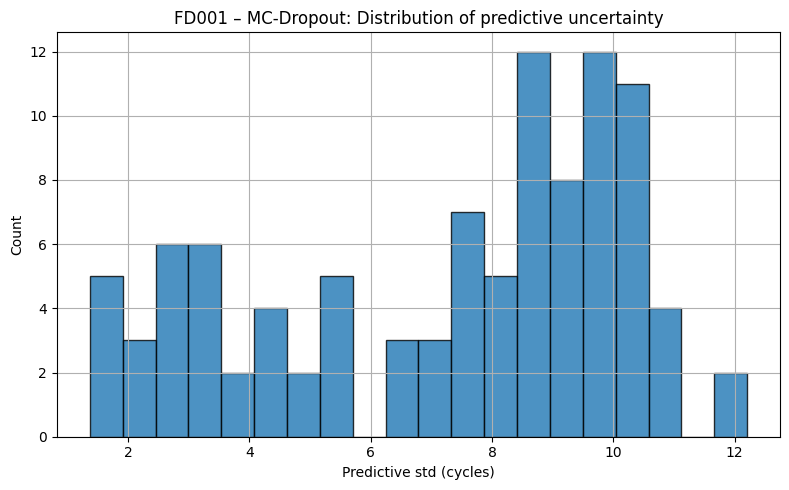

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(df["PredRUL_std"], bins=20, alpha=0.8, edgecolor="k")
plt.xlabel("Predictive std (cycles)")
plt.ylabel("Count")
plt.title("FD001 – MC-Dropout: Distribution of predictive uncertainty")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
df_sorted = df.sort_values("PredRUL_std", ascending=False)
df_sorted.head(10)[["UnitNumber", "TrueRUL", "PredRUL_mean", "PredRUL_std", "AbsError"]]


,UnitNumber,TrueRUL,PredRUL_mean,PredRUL_std,AbsError
10,"(11,)",97.0,93.231720,12.205215,3.768280
56,"(57,)",103.0,97.499680,12.175046,5.500320
21,"(22,)",111.0,106.061935,11.118896,4.938065
88,"(89,)",125.0,102.106934,11.080470,22.893066
98,"(99,)",117.0,109.418015,10.689469,7.581985
86,"(87,)",116.0,108.021248,10.622233,7.978752
84,"(85,)",118.0,108.183167,10.573292,9.816833
70,"(71,)",118.0,100.992790,10.566326,17.007210
38,"(39,)",125.0,109.195457,10.484662,15.804543
79,"(80,)",90.0,97.239952,10.371471,7.239952


New columns successfully added. Current number of columns: 30
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio
0             0.941903        0.3       0.405617
1             0.941083        1.3       0.403985
2             0.941997        1.3       0.404842
3             0.941000       -0.7       0.405550
4             0.942237       -1.7       0.404810


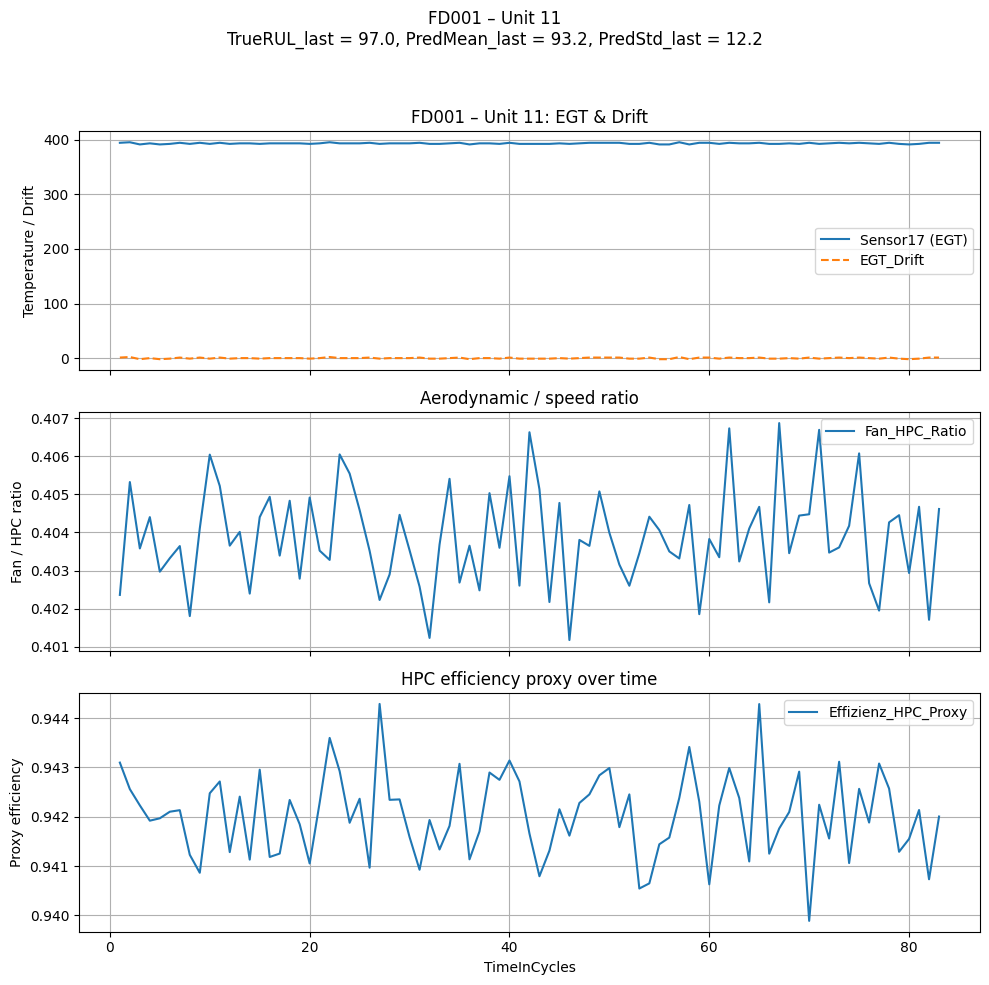

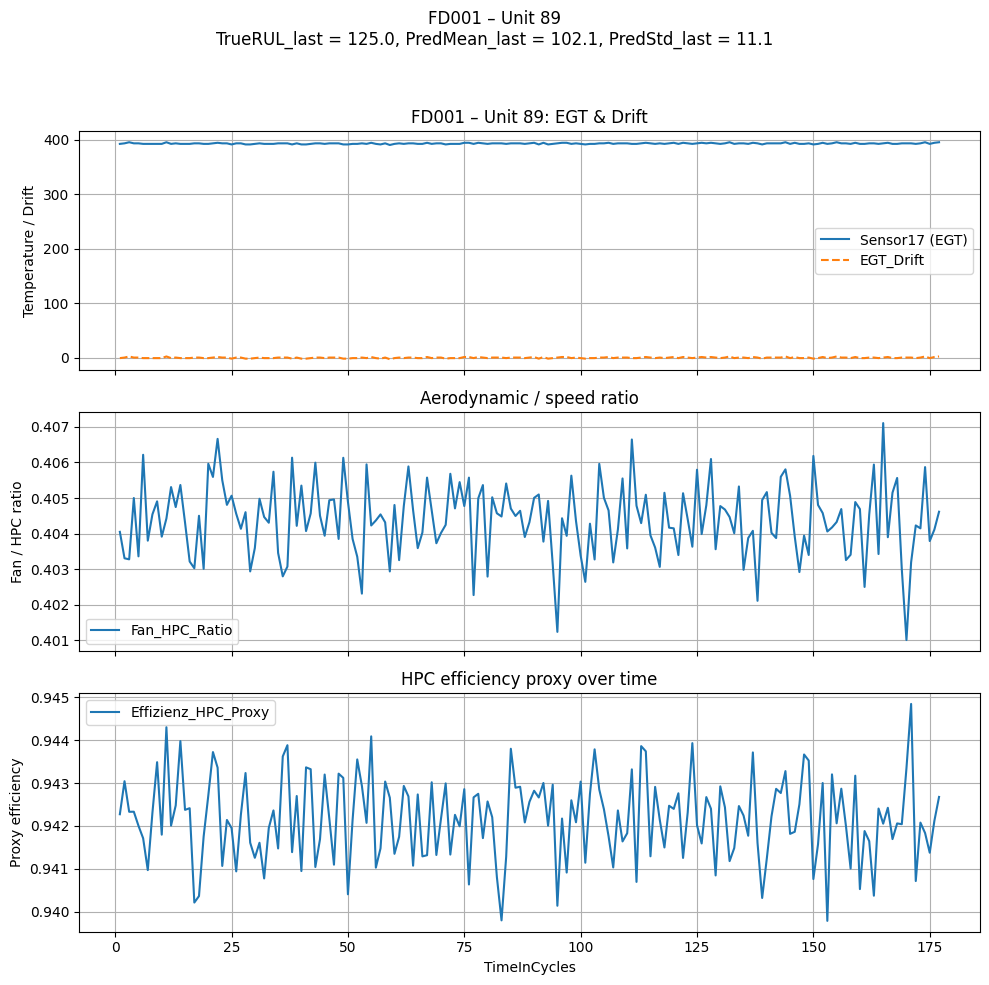

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.data_loading import load_cmapps_subset
from src.additional_features import create_physical_features
from src.config import MAX_RUL  # falls vorhanden

# 1) Testdaten + physikalische Features laden
df_train_raw, df_test_raw, y_test_true = load_cmapps_subset("FD001", max_rul=MAX_RUL)
df_test_phys = create_physical_features(df_test_raw.copy())

# Falls UnitNumber in mc_results_fd001 als Tupel wie (11,) gespeichert ist:
def normalize_unit_id(u):
    if isinstance(u, tuple):
        return u[0]
    return u

mc_results_fd001["UnitNumber_norm"] = mc_results_fd001["UnitNumber"].apply(normalize_unit_id)

def plot_fd001_unit(unit_id):
    """Plot Sensor- und Physikfeatures für eine Test-Engine."""
    # 2) Alle Zeitschritte dieser Engine holen
    df_u = df_test_phys[df_test_phys["UnitNumber"] == unit_id].copy()
    df_u = df_u.sort_values("TimeInCycles")

    # 3) Letzte Zeile aus MC-Resultaten holen
    row_mc = mc_results_fd001[mc_results_fd001["UnitNumber_norm"] == unit_id].iloc[0]

    true_rul_last = row_mc["TrueRUL"]
    pred_mean_last = row_mc["PredRUL_mean"]
    pred_std_last = row_mc["PredRUL_std"]

    t = df_u["TimeInCycles"].values
    egt = df_u["Sensor17"].values
    egt_drift = df_u["EGT_Drift"].values
    fan_hpc = df_u["Fan_HPC_Ratio"].values
    eff_hpc = df_u["Effizienz_HPC_Proxy"].values

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    # --- Plot 1: EGT & Drift ---
    ax = axes[0]
    ax.plot(t, egt, label="Sensor17 (EGT)")
    ax.plot(t, egt_drift, label="EGT_Drift", linestyle="--")
    ax.set_ylabel("Temperature / Drift")
    ax.set_title(f"FD001 – Unit {unit_id}: EGT & Drift")
    ax.grid(True)
    ax.legend()

    # --- Plot 2: Fan/HPC Ratio ---
    ax = axes[1]
    ax.plot(t, fan_hpc, label="Fan_HPC_Ratio")
    ax.set_ylabel("Fan / HPC ratio")
    ax.set_title("Aerodynamic / speed ratio")
    ax.grid(True)
    ax.legend()

    # --- Plot 3: HPC Efficiency Proxy ---
    ax = axes[2]
    ax.plot(t, eff_hpc, label="Effizienz_HPC_Proxy")
    ax.set_xlabel("TimeInCycles")
    ax.set_ylabel("Proxy efficiency")
    ax.set_title("HPC efficiency proxy over time")
    ax.grid(True)
    ax.legend()

    fig.suptitle(
        f"FD001 – Unit {unit_id}\n"
        f"TrueRUL_last = {true_rul_last:.1f}, "
        f"PredMean_last = {pred_mean_last:.1f}, "
        f"PredStd_last = {pred_std_last:.1f}",
        y=0.98,
        fontsize=12,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Beispiel: die beiden interessantesten Cases
plot_fd001_unit(11)
plot_fd001_unit(89)
